In [1]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import numpy as np

# set up initial path to data
DATADIR = 'data'
game_id = 2 # let's look at sample match 2

### Read Events and Converts Metrica Units to Meters

In [2]:
# read in the event data
events = mio.read_event_data(DATADIR, game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

events = mio.to_metric_coordinates(events)

Reading team: home
Reading team: away


### Reverse Direction of Play (180°)

In [3]:
# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)

### Calculate players velocities

In [4]:
# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

### Pitch control for passes leading up to `-GOAL`


In [5]:
# get all shots and goals in the match
shots = events[events['Type']=='SHOT']
goals = shots[shots['Subtype'].str.contains('-GOAL')].copy()

goals

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,47.70,-1.36,54.06,-2.04
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,-40.28,-1.36,-55.12,-2.72
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,30.74,-5.44,54.06,-2.72


### Plot the 3 passing leading to the goal

(<Figure size 864x576 with 1 Axes>, <Axes: >)

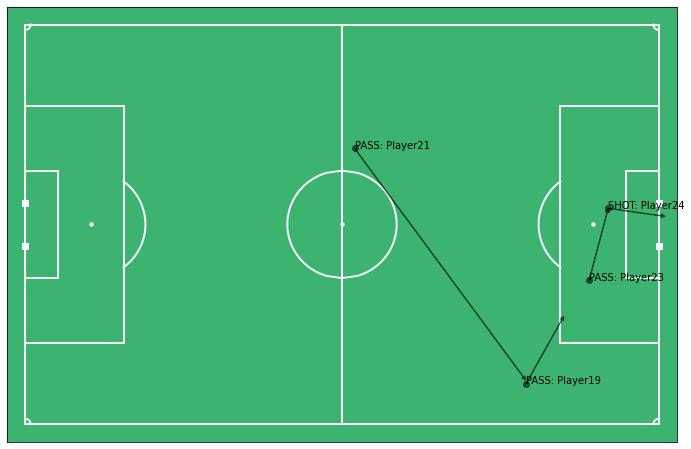

In [6]:
# plot the 3 events leading up to the second goal
mviz.plot_events( events.loc[820:823], color='k', indicators = ['Marker','Arrow'], annotate=True )

### Import Model Parameters for Pitch Control model

In [7]:
# first get pitch control model parameters
params = mpc.default_model_params()

params

{'max_player_accel': 7.0,
 'max_player_speed': 5.0,
 'reaction_time': 0.7,
 'tti_sigma': 0.45,
 'kappa_def': 1.0,
 'lambda_att': 4.3,
 'lambda_def': 4.3,
 'lambda_gk': 12.899999999999999,
 'average_ball_speed': 15.0,
 'int_dt': 0.04,
 'max_int_time': 10,
 'model_converge_tol': 0.01,
 'time_to_control_att': 3.3202550055547313,
 'time_to_control_def': 3.3202550055547313}

This line import some of the parameters that define and evaluate the model required by the pitch control model as described by W. Spearman (2018)

In [8]:
# find goalkeepers for offside calculation
GK_numbers = [mio.find_goalkeeper(tracking_home),mio.find_goalkeeper(tracking_away)]

(<Figure size 864x576 with 1 Axes>, <Axes: >)

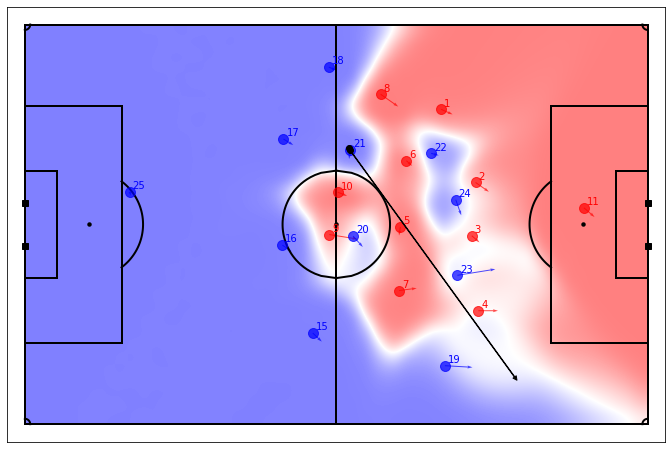

In [9]:
# evaluated pitch control surface for first pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(820, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 820, events,  tracking_home, tracking_away, PPCF, annotate=True )

(<Figure size 864x576 with 1 Axes>, <Axes: >)

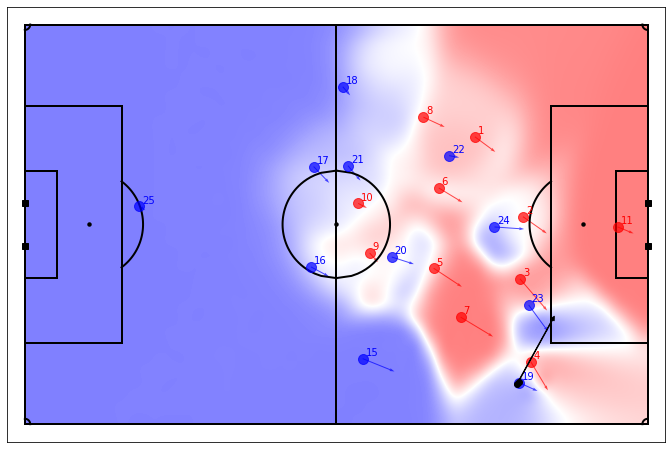

In [10]:
# evaluated pitch control surface for second pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(821, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 821, events,  tracking_home, tracking_away, PPCF, annotate=True )

(<Figure size 864x576 with 1 Axes>, <Axes: >)

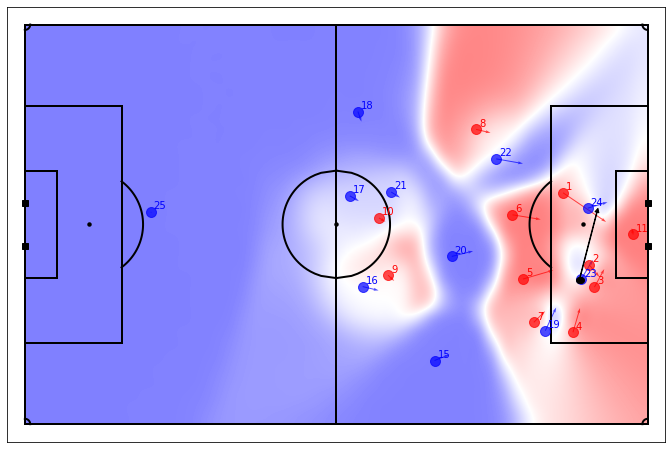

In [11]:
# evaluated pitch control surface for third pass
PPCF,xgrid,ygrid = mpc.generate_pitch_control_for_event(822, events, tracking_home, tracking_away, params, GK_numbers, field_dimen = (106.,68.,), n_grid_cells_x = 50)
mviz.plot_pitchcontrol_for_event( 822, events,  tracking_home, tracking_away, PPCF, annotate=True )

### Calculate Model Pass Probability for every home team Succesful pass

In [12]:
# get all home passes
home_passes = events[ (events['Type'].isin(['PASS'])) & (events['Team']=='Home') ]

home_passes

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
28,Home,PASS,NaN,1,1467,58.68,1489,59.56,Player1,Player11,46.64,21.08,53.00,10.20
29,Home,PASS,NaN,1,1489,59.56,1578,63.12,Player11,Player9,53.00,10.20,9.54,24.48
36,Home,PASS,HEAD,1,1672,66.88,1693,67.72,Player6,Player7,19.08,14.96,19.08,8.84
52,Home,PASS,NaN,1,2414,96.56,2440,97.60,Player3,Player8,16.96,-24.48,1.06,-29.92
53,Home,PASS,NaN,1,2465,98.60,2493,99.72,Player8,Player4,2.12,-29.92,10.60,-31.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1913,Home,PASS,NaN,2,137130,5485.20,137176,5487.04,Player5,Player1,3.18,-0.00,-8.48,12.92
1914,Home,PASS,NaN,2,137209,5488.36,137221,5488.84,Player1,Player6,-9.54,12.24,-4.24,4.76
1915,Home,PASS,NaN,2,137263,5490.52,137303,5492.12,Player6,Player1,-4.24,12.24,-12.72,21.76
1916,Home,PASS,NaN,2,137303,5492.12,137332,5493.28,Player1,Player5,-12.72,21.76,-1.06,26.52


In [13]:
# list for storing pass probablities
pass_success_probability = []

# loop through passes 
for i,row in home_passes.iterrows():
    pass_start_pos = np.array([row['Start X'],row['Start Y']])
    pass_target_pos = np.array([row['End X'],row['End Y']])
    pass_frame = row['Start Frame']
    
    attacking_players = mpc.initialise_players(tracking_home.loc[pass_frame],'Home',params, GK_numbers[0])
    defending_players = mpc.initialise_players(tracking_away.loc[pass_frame],'Away',params, GK_numbers[1])
    # calculate model probability for the current pass
    Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params)

    pass_success_probability.append( (i,Patt) )

Text(0, 0.5, 'Frequency')

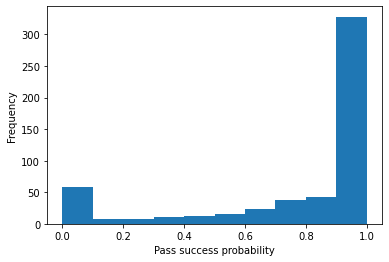

In [14]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist( [p[1] for p in pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  

In [15]:
# sort the passes by pitch control probability
pass_success_probability = sorted( pass_success_probability, key = lambda x: x[1] )

In [16]:
# identify the events corresponding to the most risky passes (pitch control < 0.5)
risky_passes = events.loc[ [p[0] for p in pass_success_probability if p[1]<0.5 ] ]

risky_passes

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1084,Home,PASS,NaN,2,72456,2898.24,72483,2899.32,Player4,Player3,-28.62,29.92,-41.34,20.40
1163,Home,PASS,NaN,2,78432,3137.28,78490,3139.60,Player2,Player11,-23.32,-24.48,-43.46,-6.80
1180,Home,PASS,NaN,2,79076,3163.04,79104,3164.16,Player7,Player2,-23.32,-1.36,-30.74,-9.52
1305,Home,PASS,NaN,2,89113,3564.52,89141,3565.64,Player4,Player3,-30.74,26.52,-40.28,21.08
1337,Home,PASS,NaN,2,90175,3607.00,90196,3607.84,Player11,Player5,-50.88,3.40,-49.82,-2.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,Home,PASS,GOAL KICK,2,86854,3474.16,86908,3476.32,Player11,Player10,-47.70,8.84,6.36,17.68
1845,Home,PASS,GOAL KICK,2,133363,5334.52,133417,5336.68,Player11,Player7,-46.64,-5.44,5.30,-27.20
1214,Home,PASS,NaN,2,80936,3237.44,80986,3239.44,Player5,Player2,8.48,-20.40,-9.54,-15.64
566,Home,PASS,NaN,1,38287,1531.48,38318,1532.72,Player4,Player7,28.62,-34.00,14.84,-30.60


(<Figure size 864x576 with 1 Axes>, <Axes: >)

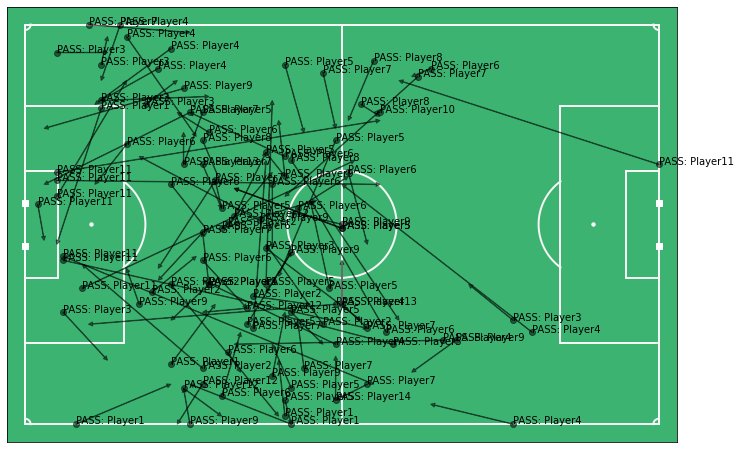

In [17]:
# plot the events
mviz.plot_events( risky_passes, color='k', indicators = ['Marker','Arrow'], annotate=True )

### What happened after those risky passes?

In [18]:
# Print events that followed those risky passes
print("Event following a risky (completed) pass")
for p in pass_success_probability[:20]:
    outcome = events.loc[ p[0]+1 ].Type
    print( p[1], outcome )

Event following a risky (completed) pass
0.0 BALL LOST
0.0 PASS
0.0 BALL OUT
0.0 PASS
0.0 BALL OUT
0.0 CHALLENGE
0.0 PASS
0.0 CHALLENGE
0.0 PASS
0.0 PASS
0.0 PASS
0.0 CHALLENGE
0.0 CHALLENGE
0.0 PASS
0.0 CHALLENGE
0.0 PASS
0.0 CHALLENGE
0.0 BALL LOST
0.0 CHALLENGE
0.0 PASS
